In [ ]:
#https://www.kaggle.com/code/harshjain123/bert-for-everyone-tutorial-implementation

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
!pip install transformers
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
 !pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pathlib import Path
print(Path.cwd())

/content


In [ ]:
import pandas as pd
df = pd.read_csv('4coldata.csv')
df.drop(['score', 'length'], inplace = True, axis = 1)
df

,y,text
0,0,used app called melody two year app includes b...
1,0,felt reasonably tired bed time got bed closed ...
2,0,hear slept poorly next day luxury
3,0,whenever warm outside bird chirp outside windo...
4,0,mirtazapine remeron past year month ago began ...
...,...,...
18394,1,day many time incredible moodiness overwhelmin...
18395,1,hi everyone new poster sub trying see anyone e...
18396,1,hard time falling asleep exhausted cant switch...
18397,1,anyone else rly want sleep feel tired get anxi...


# New section

In [ ]:
# check class distribution
df['y'].value_counts(normalize = True)

0    0.529974
1    0.470026
Name: y, dtype: float64

In [ ]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['y'], 
                                                                    random_state=20, 
                                                                    test_size=0.2, 
                                                                    stratify=df['y'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=20, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<Axes: >

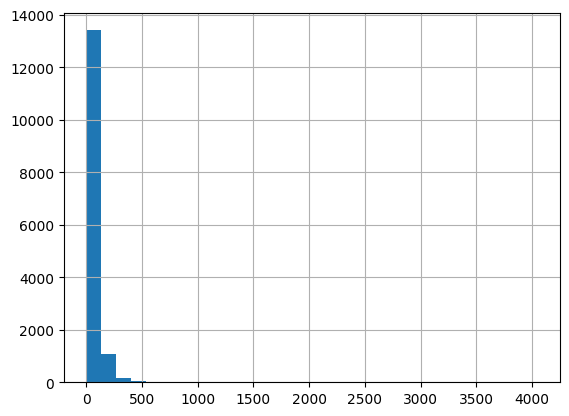

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 128,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 128,     #25
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 128,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
train_seq

tensor([[  101,  2568, 20938,  ...,     0,     0,     0],
        [  101, 10632,  4877,  ...,     0,     0,     0],
        [  101,  2668, 17996,  ...,     0,     0,     0],
        ...,
        [  101,  5681,  3637,  ...,     0,     0,     0],
        [  101,  7149, 16021,  ...,     0,     0,     0],
        [  101,  2978,  8224,  ...,  3445, 23060,   102]])

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert 
        
        # dropout layer
        self.dropout = nn.Dropout(0.4)  #0.1
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5) 

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_labels), y= train_labels)

#class_weights = dict(zip(np.unique(train_labels), class_weights))

print("Class Weights:",class_weights)

#Class Weights: [0.94340469 1.06381902]. random state 20

Class Weights: [0.94340469 1.06381902]


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 5      #10

In [ ]:
#FINE TUNE

# function to train the model
def train():
    
    model.train()
    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
import datetime
import time
#https://python-utils.readthedocs.io/en/latest/_modules/python_utils/time.html

def format_time(timestamp, precision=datetime.timedelta(seconds=1)):
    '''Formats timedelta/datetime/seconds

    >>> format_time('1')
    '0:00:01'
    >>> format_time(1.234)
    '0:00:01'
    >>> format_time(1)
    '0:00:01'
    >>> format_time(datetime.datetime(2000, 1, 2, 3, 4, 5, 6))
    '2000-01-02 03:04:05'
    >>> format_time(datetime.date(2000, 1, 2))
    '2000-01-02'
    >>> format_time(datetime.timedelta(seconds=3661))
    '1:01:01'
    >>> format_time(None)
    '--:--:--'
    >>> format_time(format_time)  # doctest: +ELLIPSIS
    Traceback (most recent call last):
        ...
    TypeError: Unknown type ...

    '''
    precision_seconds = precision.total_seconds()

    if isinstance(timestamp, six.string_types + six.integer_types + (float, )):
        try:
            castfunc = six.integer_types[-1]
            timestamp = datetime.timedelta(seconds=castfunc(timestamp))
        except OverflowError:  # pragma: no cover
            timestamp = None

    if isinstance(timestamp, datetime.timedelta):
        seconds = timestamp.total_seconds()
        # Truncate the number to the given precision
        seconds = seconds - (seconds % precision_seconds)

        return str(datetime.timedelta(seconds=seconds))
    elif isinstance(timestamp, datetime.datetime):  # pragma: no cover
        # Python 2 doesn't have the timestamp method
        if hasattr(timestamp, 'timestamp'):
            seconds = timestamp.timestamp()
        else:
            seconds = timedelta_to_seconds(timestamp - epoch)

        # Truncate the number to the given precision
        seconds = seconds - (seconds % precision_seconds)

        try:  # pragma: no cover
            if six.PY3:
                dt = datetime.datetime.fromtimestamp(seconds)
            else:
                dt = datetime.datetime.utcfromtimestamp(seconds)
        except ValueError:  # pragma: no cover
            dt = datetime.datetime.max
        return str(dt)
    elif isinstance(timestamp, datetime.date):
        return str(timestamp)
    elif timestamp is None:
        return '--:--:--'
    else:
        raise TypeError('Unknown type %s: %r' % (type(timestamp), timestamp))

In [ ]:
# function for evaluating the model
def evaluate():
    
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            
            # Calculate elapsed time in minutes.
           # elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50  of    460.
  Batch   100  of    460.
  Batch   150  of    460.
  Batch   200  of    460.
  Batch   250  of    460.
  Batch   300  of    460.
  Batch   350  of    460.
  Batch   400  of    460.
  Batch   450  of    460.

Evaluating...
  Batch    50  of     58.

Training Loss: 0.696
Validation Loss: 0.693

 Epoch 2 / 5
  Batch    50  of    460.
  Batch   100  of    460.
  Batch   150  of    460.
  Batch   200  of    460.
  Batch   250  of    460.
  Batch   300  of    460.
  Batch   350  of    460.
  Batch   400  of    460.
  Batch   450  of    460.

Evaluating...
  Batch    50  of     58.

Training Loss: 0.695
Validation Loss: 0.693

 Epoch 3 / 5
  Batch    50  of    460.
  Batch   100  of    460.
  Batch   150  of    460.
  Batch   200  of    460.
  Batch   250  of    460.
  Batch   300  of    460.
  Batch   350  of    460.
  Batch   400  of    460.
  Batch   450  of    460.

Evaluating...
  Batch    50  of     58.

Training Loss: 0.694
Validation Loss: 0.69

In [ ]:
'''Epoch 1 / 10
  Batch    50  of    460.
  Batch   100  of    460.
  Batch   150  of    460.
  Batch   200  of    460.
  Batch   250  of    460.
  Batch   300  of    460.
  Batch   350  of    460.
  Batch   400  of    460.
  Batch   450  of    460.

Evaluating...
  Batch    50  of     58.

Training Loss: 0.694
Validation Loss: 0.692

 Epoch 2 / 10
  Batch    50  of    460.
  Batch   100  of    460.
  Batch   150  of    460.
  Batch   200  of    460.
  Batch   250  of    460.
  Batch   300  of    460.
  Batch   350  of    460.
  Batch   400  of    460.
  Batch   450  of    460.

Evaluating...
  Batch    50  of     58.

Training Loss: 0.693
Validation Loss: 0.691

 Epoch 3 / 10
  Batch    50  of    460.
  Batch   100  of    460.
  Batch   150  of    460.
  Batch   200  of    460.
  Batch   250  of    460.
  Batch   300  of    460.
  Batch   350  of    460.
  Batch   400  of    460.
  Batch   450  of    460.

Evaluating...
  Batch    50  of     58.

Training Loss: 0.692
Validation Loss: 0.694

 Epoch 4 / 10
  Batch    50  of    460.
  Batch   100  of    460.
  Batch   150  of    460.
  Batch   200  of    460.
  Batch   250  of    460.
  Batch   300  of    460.
  Batch   350  of    460.
  Batch   400  of    460.
  Batch   450  of    460.

Evaluating...
  Batch    50  of     58.

Training Loss: 0.692
Validation Loss: 0.693

 Epoch 5 / 10
  Batch    50  of    460.
  Batch   100  of    460.
  Batch   150  of    460.
  Batch   200  of    460.
  Batch   250  of    460.
  Batch   300  of    460.
  Batch   350  of    460.
  Batch   400  of    460.
  Batch   450  of    460.

Evaluating...
  Batch    50  of     58.

Training Loss: 0.692
Validation Loss: 0.691

 Epoch 6 / 10
  Batch    50  of    460.
  Batch   100  of    460.
  Batch   150  of    460.
  Batch   200  of    460.
  Batch   250  of    460.
  Batch   300  of    460.
  Batch   350  of    460.
  Batch   400  of    460.
  Batch   450  of    460.

Evaluating...
  Batch    50  of     58.

Training Loss: 0.692
Validation Loss: 0.694

 Epoch 7 / 10
  Batch    50  of    460.
  Batch   100  of    460.
  Batch   150  of    460.
  Batch   200  of    460.
  Batch   250  of    460.
  Batch   300  of    460.
  Batch   350  of    460.
  Batch   400  of    460.
  Batch   450  of    460.

Evaluating...
  Batch    50  of     58.

Training Loss: 0.692
Validation Loss: 0.690

 Epoch 8 / 10
  Batch    50  of    460.
  Batch   100  of    460.
  Batch   150  of    460.
  Batch   200  of    460.
  Batch   250  of    460.
  Batch   300  of    460.
  Batch   350  of    460.
  Batch   400  of    460.
  Batch   450  of    460.

Evaluating...
  Batch    50  of     58.

Training Loss: 0.692
Validation Loss: 0.694

 Epoch 9 / 10
  Batch    50  of    460.
  Batch   100  of    460.
  Batch   150  of    460.
  Batch   200  of    460.
  Batch   250  of    460.
  Batch   300  of    460.
  Batch   350  of    460.
  Batch   400  of    460.
  Batch   450  of    460.

Evaluating...
  Batch    50  of     58.

Training Loss: 0.691
Validation Loss: 0.691

 Epoch 10 / 10
  Batch    50  of    460.
  Batch   100  of    460.
  Batch   150  of    460.
  Batch   200  of    460.
  Batch   250  of    460.
  Batch   300  of    460.
  Batch   350  of    460.
  Batch   400  of    460.
  Batch   450  of    460.

Evaluating...
  Batch    50  of     58.

Training Loss: 0.691
Validation Loss: 0.690'''

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
#MAKE PREDICTIONS

# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    #preds = model(test_seq.to(), test_mask.to())
    preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.56      0.42      0.48       975
           1       0.49      0.63      0.55       865

    accuracy                           0.52      1840
   macro avg       0.53      0.53      0.52      1840
weighted avg       0.53      0.52      0.51      1840



In [ ]:
'''         precision    recall  f1-score   support

           0       0.57      0.30      0.40       975
           1       0.49      0.74      0.59       865

    accuracy                           0.51      1840
   macro avg       0.53      0.52      0.49      1840
weighted avg       0.53      0.51      0.49      1840'''

In [ ]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection


#Count (classic BoW)
#Cvectorizer = feature_extraction.text.CountVectorizer(stop_words = 'english', max_df = 0.5, min_df = 10, max_features=200, ngram_range=(1,3))
Cvectorizer = feature_extraction.text.CountVectorizer(stop_words = 'english', min_df = 10, max_features=200, ngram_range=(1,3))
Cvectorizerv = feature_extraction.text.CountVectorizer(stop_words = 'english', min_df = 10,max_features=200, ngram_range=(1,3))
Cvectorizert = feature_extraction.text.CountVectorizer(stop_words = 'english', min_df = 10, max_features=200, ngram_range=(1,3))

#use the vectorizer on the corpus to extract a vocabulary and create the feature matrix.   #max_features=500,

#corpus = data['text'].values.astype('U')
corpustrain = train_text.values.astype('U')
Cvectorizer.fit(corpustrain)
#Cvectorizer.fit(corpus)
X_trainC = Cvectorizer.transform(corpustrain)#.toarray() 
#dic_vocabulary = Cvectorizer.vocabulary_

corpusval = val_text.values.astype('U')
Cvectorizerv.fit(corpusval)
X_valC = Cvectorizerv.transform(corpusval)#.toarray() 
#dic_vocabularyv = Cvectorizerv.vocabulary_

corpustest = test_text.values.astype('U')
Cvectorizert.fit(corpustest)
X_testC = Cvectorizert.transform(corpustest)#.toarray() 
#dic_vocabularyt = Cvectorizert.vocabulary_


namedtrain=pd.DataFrame(X_trainC.toarray(),columns=Cvectorizer.get_feature_names_out())
namedval=pd.DataFrame(X_valC.toarray(),columns=Cvectorizerv.get_feature_names_out())
namedtest=pd.DataFrame(X_testC.toarray(),columns=Cvectorizert.get_feature_names_out())

Text(0.5, 1.0, 'Sparse Matrix Count Vectorizer')

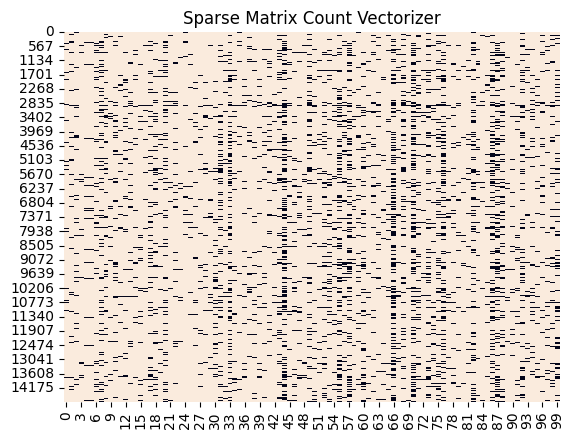

In [ ]:
import seaborn as sns 

sns.heatmap(X_trainC.todense()[:,np.random.randint(0,X_trainC.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Count Vectorizer')

In [ ]:
#Let's see the common features for train, val, and test BEFORE CHI-SQUARE

print(len(list(namedtrain.columns)), len(list(namedval.columns)), len(list(namedtest.columns)))
trainval = pd.concat([namedtrain, namedval], axis=0, join = 'inner')
three = pd.concat([trainval, namedtest], axis=0, join = 'inner')
print(three.shape)

comcol = three.columns
len(comcol)

200 200 200
(18399, 176)


176

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics

model = SVC(C = 1.0, kernel='linear')
#(C=1.0, kernel='linear', degree=3, gamma='auto')
model.fit(namedtrain[comcol], train_labels) 
predicted = model.predict(namedval[comcol])  #predict on validation set :)

print(" Accuracy:",metrics.accuracy_score(val_labels, predicted))
print("Precision:",metrics.precision_score(val_labels, predicted))
print(" Recall:",metrics.recall_score(val_labels, predicted))
print(" F1:",metrics.f1_score(val_labels, predicted))

 Accuracy: 0.5472826086956522
Precision: 0.5536912751677853
 Recall: 0.1907514450867052
 F1: 0.2837489251934652


In [ ]:
'''from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': [0.1, 1, 10]}
  
grid = GridSearchCV(SVC(kernel = 'linear'), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(namedtrain,train_labels)'''

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .............................C=0.1;, score=0.545 total time= 1.2min
[CV 2/5] END .............................C=0.1;, score=0.541 total time= 1.1min
[CV 3/5] END .............................C=0.1;, score=0.534 total time= 1.1min
[CV 4/5] END .............................C=0.1;, score=0.546 total time= 1.1min
[CV 5/5] END .............................C=0.1;, score=0.546 total time= 1.1min
[CV 1/5] END ...............................C=1;, score=0.539 total time= 3.5min
[CV 2/5] END ...............................C=1;, score=0.540 total time= 3.4min
[CV 3/5] END ...............................C=1;, score=0.533 total time= 3.5min
[CV 4/5] END ...............................C=1;, score=0.544 total time= 3.4min
[CV 5/5] END ...............................C=1;, score=0.544 total time= 3.5min
[CV 1/5] END ..............................C=10;, score=0.541 total time=25.2min


In [ ]:
# combine train and validate sets for shared features

print('namedtrain shape:', namedtrain.shape, 'namedval shape:', namedval.shape)
X_train = pd.concat([namedtrain[comcol], namedval[comcol]], axis=0, join = 'inner')
print('X_train shape:', X_train.shape)
#X_train.columns = [''] * len(X_train.columns)
Y_train = pd.concat([train_labels, val_labels], axis=0)
print('Y_train shape:', Y_train.shape, 'y_train shape:', train_labels.shape, 'y_val shape:', val_labels.shape)

namedtrain shape: (14719, 200) namedval shape: (1840, 200)
X_train shape: (16559, 176)
Y_train shape: (16559,) y_train shape: (14719,) y_val shape: (1840,)


In [ ]:
X_test = namedtest[comcol]
#X_test.columns = [''] * len(namedtest[comcol].columns)
X_test

,able,able sleep,actually,advice,ago,ambien,anxiety,anxious,anymore,asleep,...,way,week,weird,went,woke,work,worked,working,worse,year
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1835,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1836,0,0,0,0,0,0,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1838,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics

model2 = SVC(C = 10, kernel='linear')
model2.fit(X_train,Y_train) 
predicted = model2.predict(X_test)  #predict on test set :)

print(" Accuracy:",metrics.accuracy_score(test_labels, predicted))
print("Precision:",metrics.precision_score(test_labels, predicted))
print(" Recall:",metrics.recall_score(test_labels, predicted))
print(" F1:",metrics.f1_score(test_labels, predicted))

 Accuracy: 0.5413043478260869
Precision: 0.5421686746987951
 Recall: 0.15606936416184972
 F1: 0.24236983842010773


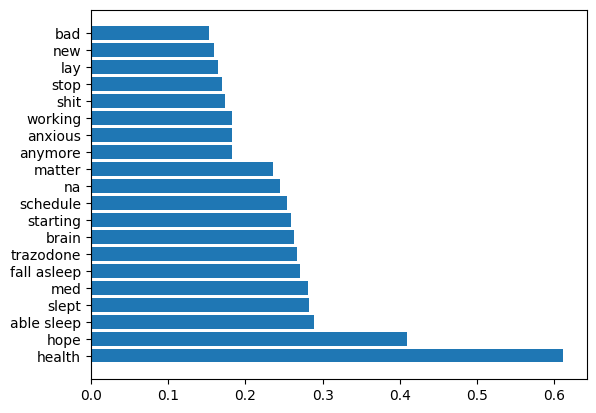

In [ ]:
from matplotlib import pyplot as plt
from sklearn import svm

def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

# whatever your features are called
feature_names = list(X_train.columns)
svm = svm.SVC(kernel='linear', C= 1.0)
svm.fit(X_train, Y_train)    ### TRAIN + VAL SET COMBINED  ##200 max feature

# Specify your top n features you want to visualize.
# You can also discard the abs() function if you are interested in negative contribution
#of features
f_importances(abs(svm.coef_[0]), feature_names, top=20)